In [1]:
MAX_EPOCHS=100
IMG_SIZE = 28
OUT_CLASSES = 10
BATCH_SIZE=64
LR = 3e-4

#### Install Dataset from https://huggingface.co/datasets/ylecun/mnist

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("ylecun/mnist", split="train")
test_dataset = load_dataset("ylecun/mnist", split="test")

#### Take a look at dataset 

label: 5


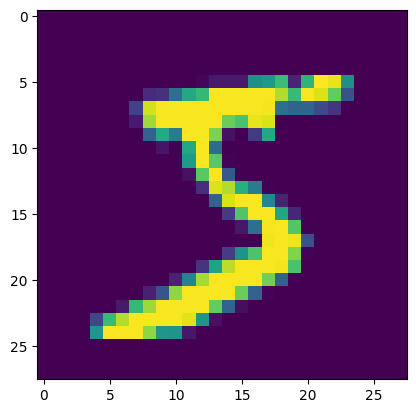

In [3]:
from PIL import Image
from matplotlib import pyplot

sample = next(iter(train_dataset))
image, label = sample["image"], sample["label"]
pyplot.imshow(image)
print(f"label: {label}")

#### Define collate function. Preprocess labels and images at this step

In [4]:
from torchvision import transforms
import torch

img2tensor = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # resize to 28*28
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

def train_collate_fn(samples):
    images = []
    labels = []
    
    for image, label in [(sample["image"], sample["label"]) for sample in samples]:
        image_tensor = img2tensor(image)

        images.append(image_tensor)
        labels.append(label)

    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels

def test_collate_fn(samples):
    images = []
    labels = []
    
    for image, label in [(sample["image"], sample["label"]) for sample in samples]:
        image_tensor = img2tensor(image)

        images.append(image_tensor)
        labels.append(label)

    images = torch.stack(images)
    labels = torch.tensor(labels)
    return images, labels


#### Define MNIST Classifier Model

In [5]:
import torch.nn as nn 

class Mnist_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 14 * 14, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)

        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x

#### Test the model using torchinfo.summary

In [6]:
from torchinfo import summary
model = Mnist_Classifier()
summary(model, input_size=(BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Mnist_Classifier                         [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─ReLU: 1-2                              [64, 32, 28, 28]          --
├─Conv2d: 1-3                            [64, 64, 28, 28]          18,496
├─ReLU: 1-4                              [64, 64, 28, 28]          --
├─MaxPool2d: 1-5                         [64, 64, 14, 14]          --
├─Flatten: 1-6                           [64, 12544]               --
├─Linear: 1-7                            [64, 4096]                51,384,320
├─ReLU: 1-8                              [64, 4096]                --
├─Linear: 1-9                            [64, 1024]                4,195,328
├─ReLU: 1-10                             [64, 1024]                --
├─Linear: 1-11                           [64, 10]                  10,250
├─LogSoftmax: 1-12                       [64, 10]            

#### Define lightning module

In [7]:
import lightning as L
from torch.utils.data import DataLoader
import numpy as np 

class Lit_Mnist_Classifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.lr = LR
        self.batch_size = BATCH_SIZE
        self.criterion = nn.NLLLoss()

        self.train_losses = []
        self.val_losses = []
        self.val_total = 0
        self.val_correct = 0

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)

        train_loss = self.criterion(outputs, labels)
        self.train_losses.append(train_loss.item())

        return train_loss
    def on_train_epoch_end(self):
        # print the average train_loss 
        print(f"Average Training Loss in EPOCH #{self.current_epoch}: {np.mean(self.train_losses)}")
        self.train_losses = []
        return
        

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)

        val_loss = self.criterion(outputs, labels)

        # get the validation accuracy
        _, predictions = torch.max(outputs, dim=-1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                self.val_total += 1
                self.val_correct += 1
            else:
                self.val_total += 1

    def on_validation_epoch_end(self):
        # print the average val_loss 
        print(f"Average Validation Loss in EPOCH #{self.current_epoch}: {np.mean(self.val_losses)}")
        
        # print the validation accuracy
        print(f"Validation Accuracy in EPOCH #{self.current_epoch}: {self.val_correct / self.val_total * 100:.2f}%")
        self.val_losses = []
        self.val_correct = 0
        self.val_total = 0
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, shuffle=True, collate_fn=train_collate_fn, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(test_dataset, shuffle=False, collate_fn=test_collate_fn, batch_size=self.batch_size)

#### Train with Lightning Trainer

In [8]:
from lightning.pytorch.callbacks import RichProgressBar

lit_model = Lit_Mnist_Classifier(model)

trainer = L.Trainer(
    val_check_interval=1.0,
    max_epochs=MAX_EPOCHS, 
    num_sanity_val_steps=0,
    callbacks=[RichProgressBar()],
)

trainer.fit(lit_model)

Epoch 3/99 ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 529/938 0:00:44 • 0:00:35 12.00it/s v_num: 9.000


Detected KeyboardInterrupt, attempting graceful shutdown ...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1059c1790>>
Traceback (most recent call last):
  File "/Volumes/workspace/projects/mnist-torch-lightning/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


NameError: name 'exit' is not defined

#### Let's predict the number in the image using the trained model!

Model predicted the image's number as 2


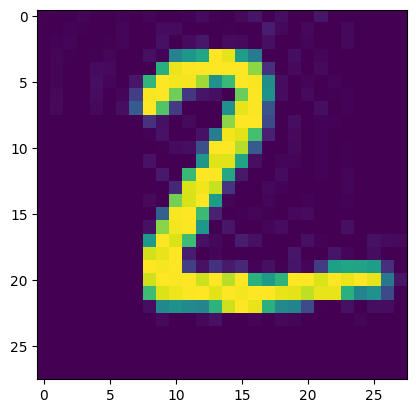

In [10]:
from PIL import Image

img_path = "./images/example.jpg"
image = Image.open(img_path)
pyplot.imshow(image)

# convert the image to tensor 
image = img2tensor(image)

# since model gets images as batch, just exend the dim 0 
image = image.unsqueeze(0)

outputs = model(image)

_, predictions = torch.max(outputs, dim=-1)

prediction = predictions[0]
print(f"Model predicted the image's number as {prediction}")